## <b><u> Netflix Content Strategy Analysis with Python </b> </u>

##### Netflix, one of the world’s leading streaming platforms, offers thousands of movies, TV shows, and documentaries across multiple languages and regions. With an ever-growing global audience, Netflix continually refines its content strategy — deciding what type of content to produce, promote, or license — based on viewer engagement metrics like hours viewed, availability, and audience reach.

    This project aims to analyze Netflix’s content catalog and viewing trends to uncover insights that can guide strategic decisions such as:

    Which types of content (Movies vs. TV Shows) perform better globally?

    How does language influence viewership and engagement?

    Are globally available titles more successful?

    How does release year affect viewership (do older titles still perform well)?

    Can we predict or cluster content based on performance indicators?

    We’ll use Python and popular data analysis libraries like pandas, numpy, matplotlib, seaborn, and scikit-learn to: Load and clean the dataset.

    Perform Exploratory Data Analysis (EDA) to understand key patterns.

    Visualize relationships between factors like release date, language, and hours viewed.

    Apply machine learning models to predict and cluster content performance.

    Derive actionable insights to inform Netflix’s content investment strategy.

By the end of this analysis, we’ll have both data-driven insights and a hands-on understanding of Python data analytics — from basic data wrangling to advanced predictive modeling.

#### This Jupyter-style notebook guides you step-by-step through a complete project analyzing Netflix content strategy using a dataset with the following columns:


- `Title`
- `Available Globally` (Yes/No or boolean)
- `Release Date` (string or date)
- `Hours Viewed` (numeric — total hours viewed)
- `Language Indicator` (language or languages)
- `Content Type` (e.g., Movie, TV Show)

### <u>  Importing Necessary Libraries </u>

In [2]:
import os 
import warnings
warnings.filterwarnings ('ignore')

In [3]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# scikit- learn for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report


# Models
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)


print("Imports done. Python packages versions:")
print(f"pandas: {pd.__version__}, numpy: {np.__version__}")

Imports done. Python packages versions:
pandas: 2.2.1, numpy: 1.26.4


### 1. <u>  Load data </u>

In [4]:
df = pd.read_csv('netflix_content.csv')


### 2. <u> show head if loaded </u>

In [5]:
display(df.head())

,Title,Available Globally?,Release Date,Hours Viewed,Language Indicator,Content Type
0,The Night Agent: Season 1,Yes,2023-03-23,"81,21,00,000",English,Show
1,Ginny & Georgia: Season 2,Yes,2023-01-05,"66,51,00,000",English,Show
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,2022-12-30,"62,28,00,000",Korean,Show
3,Wednesday: Season 1,Yes,2022-11-23,"50,77,00,000",English,Show
4,Queen Charlotte: A Bridgerton Story,Yes,2023-05-04,"50,30,00,000",English,Movie


### <u>  We'll inspect data types, missing values, duplicates and basic statistics. </u>

In [6]:
if df.empty:
    print( "Data is not loaded yet -- Please load your CSV or synthetic data.")
else:
    print("Dataframe Shape: ",df.shape)
    display(df.info)
    display (df.describe(include='all').T)

    # missing-values
    missing= df.isnull().sum().sort_values(ascending=False)
    display(missing[missing>0])

    # duplicates
    print("Duplicate rows: ", df.duplicated().sum())

Dataframe Shape:  (24812, 6)


<bound method DataFrame.info of                                               Title Available Globally? Release Date  Hours Viewed Language Indicator Content Type
0                         The Night Agent: Season 1                 Yes   2023-03-23  81,21,00,000            English         Show
1                         Ginny & Georgia: Season 2                 Yes   2023-01-05  66,51,00,000            English         Show
2                The Glory: Season 1 // 더 글로리: 시즌 1                 Yes   2022-12-30  62,28,00,000             Korean         Show
3                               Wednesday: Season 1                 Yes   2022-11-23  50,77,00,000            English         Show
4               Queen Charlotte: A Bridgerton Story                 Yes   2023-05-04  50,30,00,000            English        Movie
...                                             ...                 ...          ...           ...                ...          ...
24807            We Are Black and British: Season 1

,count,unique,top,freq
Title,24812,19158,The Night Agent: Season 1,2
Available Globally?,24812,2,No,17162
Release Date,8166,1783,2020-03-20,28
Hours Viewed,24812,889,"1,00,000",4046
Language Indicator,24812,6,English,17268
Content Type,24812,2,Movie,14104


Release Date    16646
dtype: int64

Duplicate rows:  467


###  3. <u>Data Cleaning  </u>
 Steps:
 - Standardize column names
 - Convert `Release Date` to datetime (if not already)
 - Convert `Available Globally` to boolean
 - Clean `Hours Viewed` to numeric
 - Normalize languages (split if multiple)
 - Remove duplicates and handle missing values depending on column importance

In [7]:
# Only run cleaning if df is present
if not df.empty:
# copy to avoid changing original unexpectedly
    data = df.copy()
    
# standardize column names
data.columns =[c.strip().replace(' ','_').lower() for c in data.columns]
display(data.columns)

# rename to predictable names if necessary
# release_date may have different name; checking common variants
if 'release_date' not in data.columns and 'release date' in data.columns:
    data.rename(columns={'release date':'release_date'}, inplace=True)

# convert release_date
data['release_date']=pd.to_datetime(data['release_date'], errors='coerce')

# available_globally to boolean
if 'available_globally' in data.columns:
    data['available_globally'] = data['available_globally'].astype(str).str.strip().str.lower().map({'yes':True,'y':True,'true':True,'1':'True','no':False,'n':False,'false':False,'0':False})

# hours_viewed to numeric
if 'hours_viewed' in data.columns:
    data['hours_viewed'] = pd.to_numeric(data['hours_viewed'], errors='coerce')


# content_type clean
if 'content_type' in data.columns:
    data['content_type'] = data['content_type'].astype(str).str.strip().str.title()


# language indicator
if 'language_indicator' in data.columns:
    data['language_indicator'] = data['language_indicator'].astype(str).str.strip()


# drop true duplicate rows
before = data.shape[0]
data = data.drop_duplicates(subset=['title','release_date']) if all(col in data.columns for col in ['title','release_date']) else data.drop_duplicates()
after = data.shape[0]
print(f"Dropped {before-after} duplicate rows")


# report missing after cleaning
display(data.isnull().sum().sort_values(ascending=False).head(20))


Index(['title', 'available_globally?', 'release_date', 'hours_viewed', 'language_indicator', 'content_type'], dtype='object')

Dropped 5653 duplicate rows


hours_viewed           19159
release_date           14040
title                      0
available_globally?        0
language_indicator         0
content_type               0
dtype: int64

### 4.<u> Exploratory Data Analysis (EDA) — Basic </u>


Use pandas, matplotlib and seaborn to answer baseline questions:
- Which content types are most common?
- What languages are most represented?
- How many titles are available globally?
- Distribution of `Hours Viewed` (skewness/outliers)

Content type counts:


content_type
Movie    12702
Show      6457
Name: count, dtype: int64

Top languages:


language_indicator
English        13059
Non-English     2712
Japanese        1673
Korean          1346
Hindi            334
Russian           35
Name: count, dtype: int64

Availability globally:


available_globally?
No     14361
Yes     4798
Name: count, dtype: int64

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: hours_viewed, dtype: float64

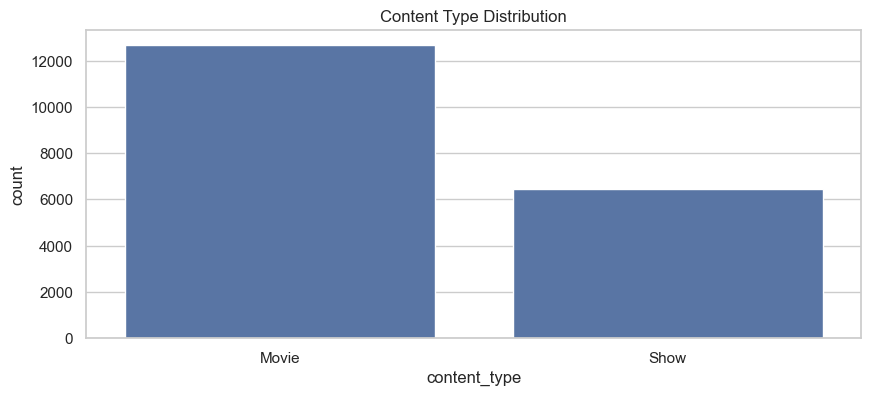

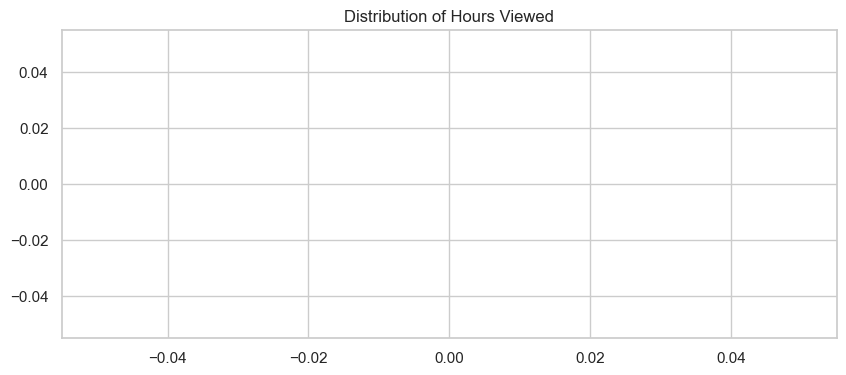

In [8]:
if not df.empty:
# basic counts
    print("Content type counts:")
display(data['content_type'].value_counts())


print("Top languages:")
display(data['language_indicator'].value_counts().head(10))


print("Availability globally:")
display(data['available_globally?'].value_counts(dropna=False))


# hours viewed summary
display(data['hours_viewed'].describe())

# plots
plt.figure(figsize=(10,4))
sns.countplot(data=data, x='content_type', order=data['content_type'].value_counts().index)
plt.title('Content Type Distribution')
plt.show()


plt.figure(figsize=(10,4))
sns.histplot(data['hours_viewed'].dropna(), bins=50)
plt.title('Distribution of Hours Viewed')
plt.show()

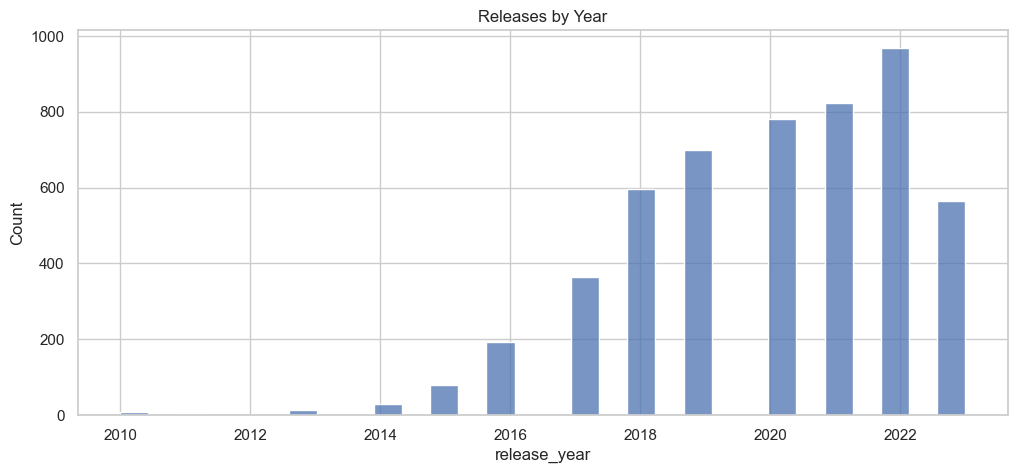

,release_year,count,sum,mean,median
0,2010.0,0,0.0,NaN,NaN
1,2011.0,0,0.0,NaN,NaN
2,2012.0,0,0.0,NaN,NaN
3,2013.0,0,0.0,NaN,NaN
4,2014.0,0,0.0,NaN,NaN
5,2015.0,0,0.0,NaN,NaN
6,2016.0,0,0.0,NaN,NaN
7,2017.0,0,0.0,NaN,NaN
8,2018.0,0,0.0,NaN,NaN
9,2019.0,0,0.0,NaN,NaN


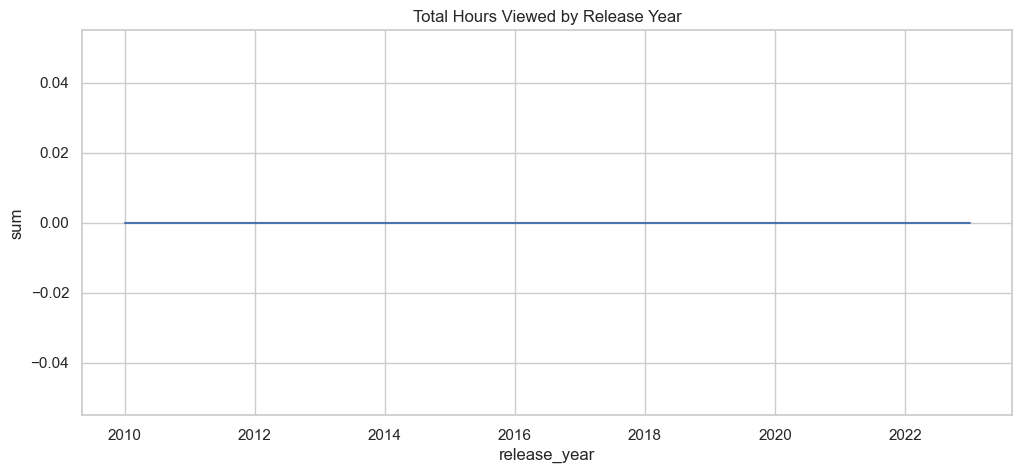

In [12]:
if not df.empty:
    data['release_year'] = data['release_date'].dt.year
plt.figure(figsize=(12,5))
sns.histplot(data['release_year'].dropna(), bins=30)
plt.title('Releases by Year')
plt.show()


# aggregate hours viewed by year (mean, median, total)
agg_by_year = data.groupby('release_year')['hours_viewed'].agg(['count','sum','mean','median']).reset_index()
display(agg_by_year.sort_values('release_year').head(10))


plt.figure(figsize=(12,5))
sns.lineplot(data=agg_by_year, x='release_year', y='sum')
plt.title('Total Hours Viewed by Release Year')
plt.show()

### 6. <u> EDA — Language and Global Availability </u>


Analyze languages and how availability globally impacts hours viewed.

In [29]:
'1,234,567'
'2.5M'
'500K'
'-'
' '


' '

In [31]:
print(df.columns.tolist())


['Title', 'Available Globally?', 'Release Date', 'Hours Viewed', 'Language Indicator', 'Content Type']


In [32]:
data['hours_viewed'] = (
    df['Hours Viewed']
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
    .replace('', np.nan)
    .astype(float)
)


In [35]:

# Clean and convert 'Hours Viewed' column to numeric
data['hours_viewed'] = (
    df['Hours Viewed']
    .astype(str)
    .str.replace(',', '', regex=False)   # remove commas like 1,00,000
    .str.strip()                         # remove spaces
    .replace('', np.nan)                 # empty strings → NaN
)

# Convert to numeric (float)
data['hours_viewed'] = pd.to_numeric(data['hours_viewed'], errors='coerce')

# Check results
print(data['hours_viewed'].describe())


count    1.915900e+04
mean     5.813383e+06
std      2.099151e+07
min      1.000000e+05
25%      2.000000e+05
50%      8.000000e+05
75%      3.700000e+06
max      8.121000e+08
Name: hours_viewed, dtype: float64


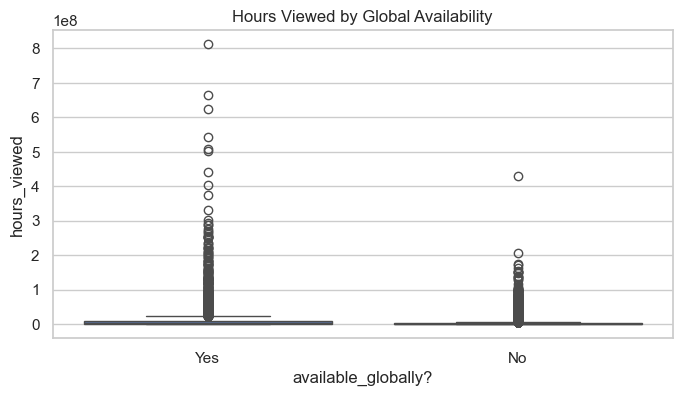

In [36]:

plt.figure(figsize=(8,4))
sns.boxplot(data=data, x='available_globally?', y='hours_viewed')
plt.title('Hours Viewed by Global Availability')
plt.show()


Interpretation of the Boxplot

1. X-axis: Two categories — Yes (Available Globally) and No (Not Available Globally).

2. Y-axis: Hours Viewed — shows how much time people spent watching that content.

3. What the chart shows:

    Both groups have most data points near the lower range (bottom of the box), meaning many titles get modest viewership.

    The tall vertical spread (with dots) represents outliers — extremely popular shows or movies that got hundreds of millions of viewing hours.

    The “Yes” category has more high outliers — meaning globally available content tends to attract much higher viewership than region-locked content.

Compare viewership by content type

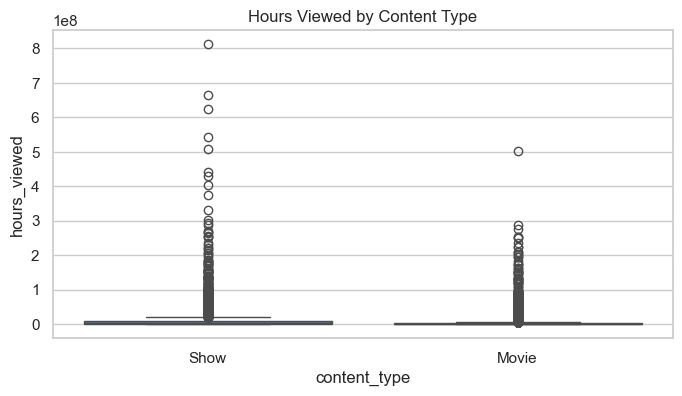

In [37]:
plt.figure(figsize=(8,4))
sns.boxplot(data=data, x='content_type', y='hours_viewed')
plt.title('Hours Viewed by Content Type')
plt.show()


Viewership by language

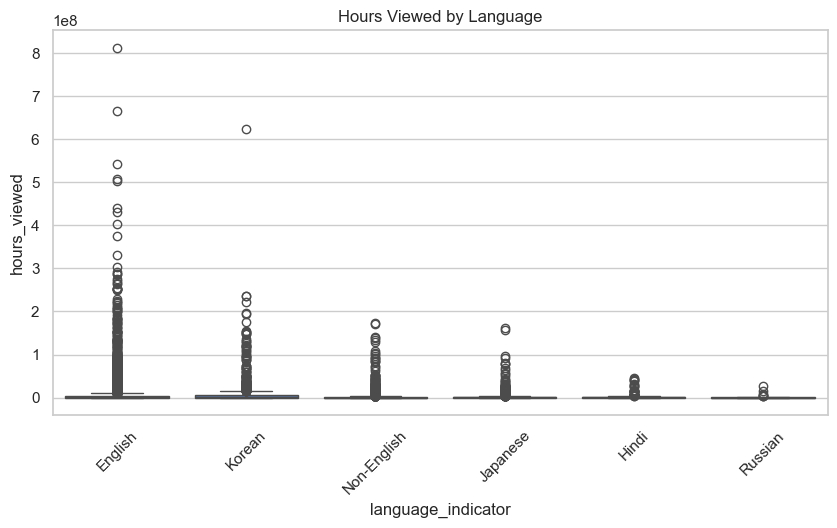

In [38]:
top_langs = data['language_indicator'].value_counts().head(10).index
plt.figure(figsize=(10,5))
sns.boxplot(data=data[data['language_indicator'].isin(top_langs)],
            x='language_indicator', y='hours_viewed')
plt.xticks(rotation=45)
plt.title('Hours Viewed by Language')
plt.show()


Trend over time (release date vs. hours viewed)

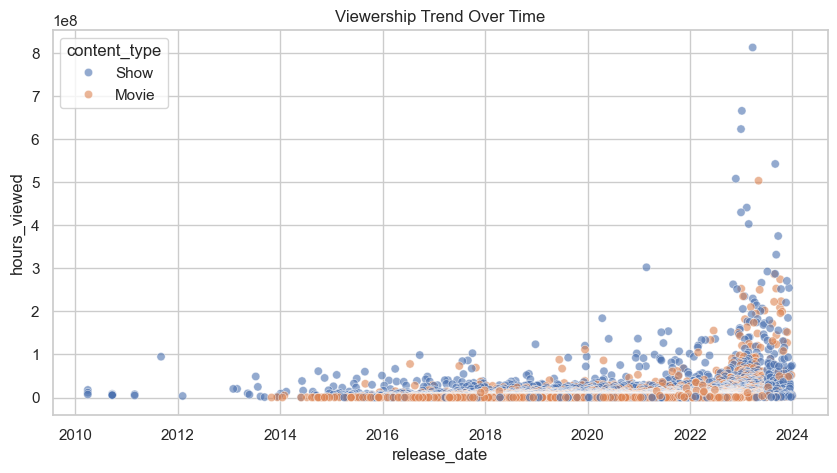

In [39]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x='release_date', y='hours_viewed', hue='content_type', alpha=0.6)
plt.title('Viewership Trend Over Time')
plt.show()


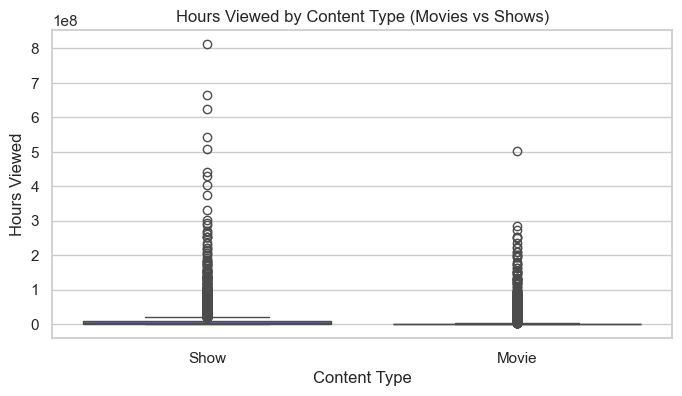

Average Hours Viewed by Content Type:
content_type
Show     1.057838e+07
Movie    3.391120e+06
Name: hours_viewed, dtype: float64


In [40]:
# Boxplot of Hours Viewed by Content Type
plt.figure(figsize=(8,4))
sns.boxplot(data=data, x='content_type', y='hours_viewed')
plt.title('Hours Viewed by Content Type (Movies vs Shows)')
plt.xlabel('Content Type')
plt.ylabel('Hours Viewed')
plt.show()

# Also check average hours viewed per type
avg_viewership = data.groupby('content_type')['hours_viewed'].mean().sort_values(ascending=False)
print("Average Hours Viewed by Content Type:")
print(avg_viewership)


Interpretation:

    If Movies show higher boxes or more outliers, it means that big Netflix movies often get high viewing hours.

    If Shows dominate, it means series (with multiple episodes) are driving more total viewing time.

    Outliers (circles above the box) represent super popular titles — like “Wednesday” or “The Night Agent.”

Netflix’s Top 10 Most-Watched Titles

,title,hours_viewed,content_type,language_indicator,available_globally?
0,The Night Agent: Season 1,812100000,Show,English,Yes
1,Ginny & Georgia: Season 2,665100000,Show,English,Yes
2,The Glory: Season 1 // 더 글로리: 시즌 1,622800000,Show,Korean,Yes
18214,ONE PIECE: Season 1,541900000,Show,English,Yes
3,Wednesday: Season 1,507700000,Show,English,Yes
4,Queen Charlotte: A Bridgerton Story,503000000,Movie,English,Yes
5,You: Season 4,440600000,Show,English,Yes
6,La Reina del Sur: Season 3,429600000,Show,English,No
7,Outer Banks: Season 3,402500000,Show,English,Yes
18219,Sex Education: Season 4,374700000,Show,English,Yes


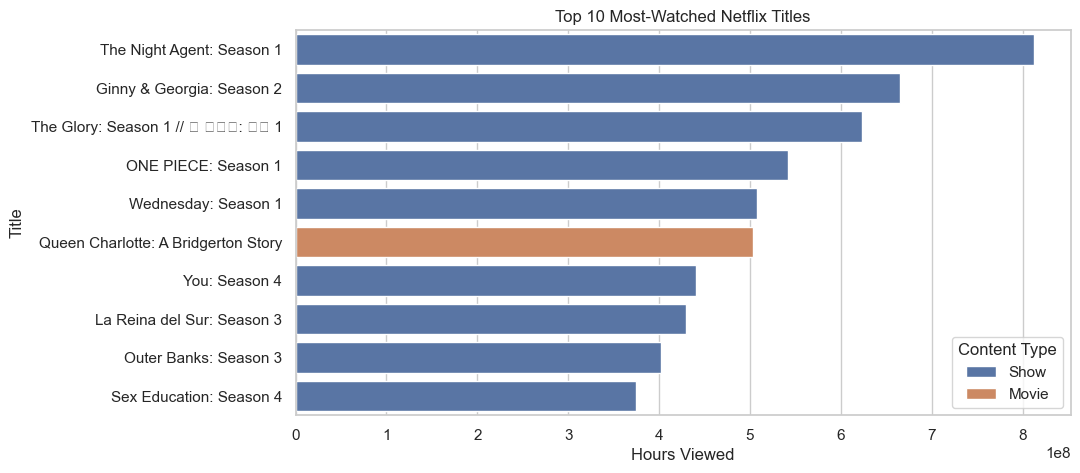

In [42]:
# Top 10 most-watched titles
top_titles = data.sort_values(by='hours_viewed', ascending=False).head(10)
display(top_titles[['title', 'hours_viewed', 'content_type', 'language_indicator', 'available_globally?']])

# Plot
plt.figure(figsize=(10,5))
sns.barplot(data=top_titles, y='title', x='hours_viewed', hue='content_type', dodge=False)
plt.title('Top 10 Most-Watched Netflix Titles')
plt.xlabel('Hours Viewed')
plt.ylabel('Title')
plt.legend(title='Content Type')
plt.show()


Interpretation:

    Most of the Top 10 titles are Shows — confirming that series dominate Netflix viewing.

    All top titles are available globally, reinforcing the importance of worldwide reach.

    The presence of non-English hits (like Korean shows) highlights Netflix’s international strategy.

In [44]:
# Convert release_date column to datetime format
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

# Extract year
data['release_year'] = data['release_date'].dt.year


In [45]:
# Group by release year and calculate total hours viewed
yearly_trend = data.groupby('release_year')['hours_viewed'].sum().reset_index()


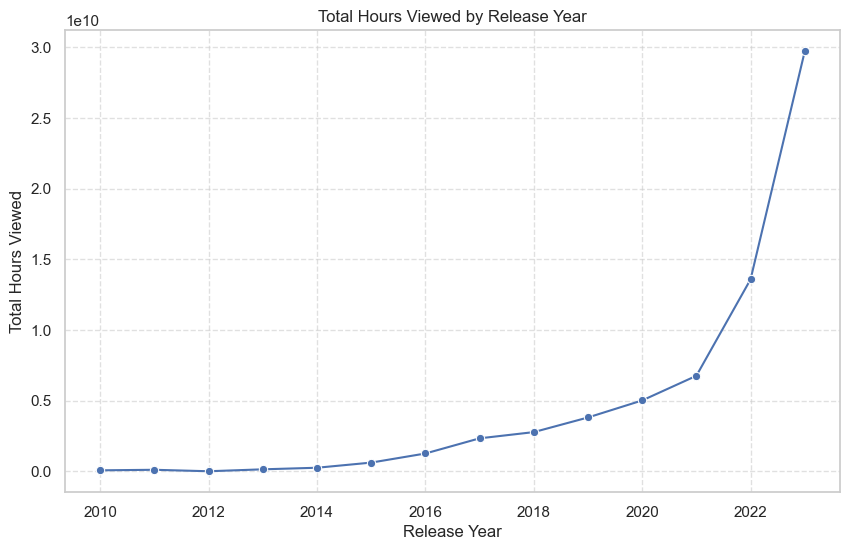

In [46]:
# Plot total hours viewed over time
plt.figure(figsize=(10,6))
sns.lineplot(data=yearly_trend, x='release_year', y='hours_viewed', marker='o')
plt.title('Total Hours Viewed by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Total Hours Viewed')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Interpretation:

    Upward trend (especially post-2019): indicates Netflix’s global expansion and rise in streaming popularity.

    Dip during 2020–2021 could reflect production delays from the pandemic.

    Recent years (2022–2024) may show growth again with big hits and diversified international content.

## 7. <u> Advanced EDA — Correlations and outliers </u>

Numeric columns: ['hours_viewed', 'release_year']


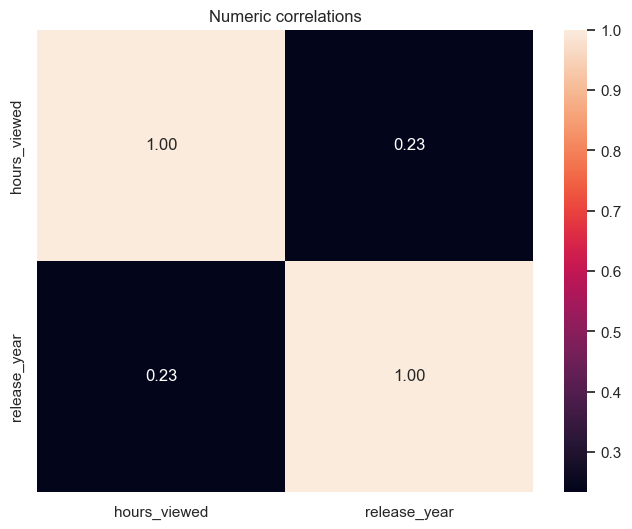

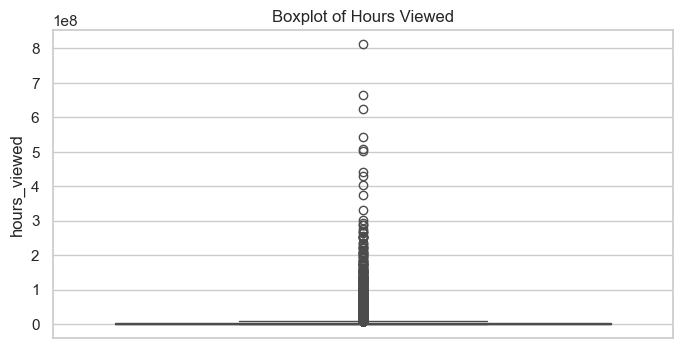

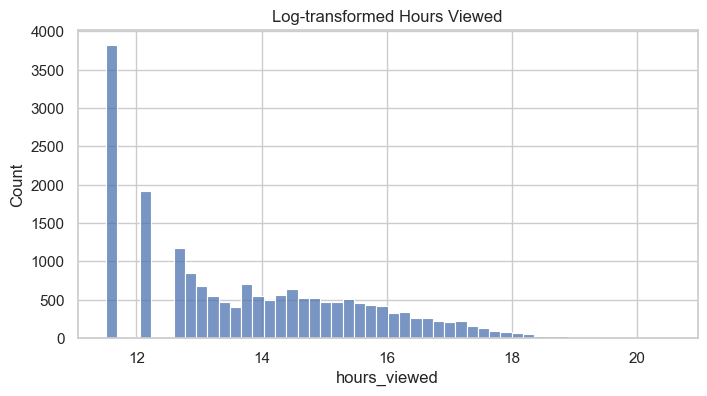

In [49]:
if not df.empty:
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    print('Numeric columns:', numeric_cols)
if len(numeric_cols) > 1:
    plt.figure(figsize=(8,6))
    sns.heatmap(data[numeric_cols].corr(), annot=True, fmt='.2f')
    plt.title('Numeric correlations')
    plt.show()


    plt.figure(figsize=(8,4))
    sns.boxplot(y=data['hours_viewed'].dropna())
    plt.title('Boxplot of Hours Viewed')
    plt.show()


# If heavily skewed, consider log transform
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(data['hours_viewed'].dropna()), bins=50)
plt.title('Log-transformed Hours Viewed')
plt.show()

###  8. <u> Feature Engineering</u> 
Create features useful for modeling:
- `release_year` (done)
- `is_global` boolean
- `language_top` flag for top languages
- `title_length`
- `age_of_content` (current year - release_year)

In [52]:
if not df.empty:
    data['is_global'] = data['available_globally?'].astype(bool)
    top_langs = data['language_indicator'].value_counts().nlargest(6).index.tolist()
    data['language_top'] = data['language_indicator'].apply(lambda x: x if x in top_langs else 'Other')
    data['title_length'] = data['title'].astype(str).apply(len)
    current_year = pd.Timestamp.now().year
    data['age_of_content'] = data['release_year'].apply(lambda y: current_year - y if not pd.isnull(y) else np.nan)
display(data[['title','release_date','release_year','hours_viewed','is_global','language_top','title_length','age_of_content']].head())


,title,release_date,release_year,hours_viewed,is_global,language_top,title_length,age_of_content
0,The Night Agent: Season 1,2023-03-23,2023.0,812100000,True,English,25,2.0
1,Ginny & Georgia: Season 2,2023-01-05,2023.0,665100000,True,English,25,2.0
2,The Glory: Season 1 // 더 글로리: 시즌 1,2022-12-30,2022.0,622800000,True,Korean,34,3.0
3,Wednesday: Season 1,2022-11-23,2022.0,507700000,True,English,19,3.0
4,Queen Charlotte: A Bridgerton Story,2023-05-04,2023.0,503000000,True,English,35,2.0


### 9. <u>Clustering (unsupervised) — find content groups</u>
We'll cluster titles using features such as `hours_viewed` (log-transformed), `age_of_content`, and `title_length`.

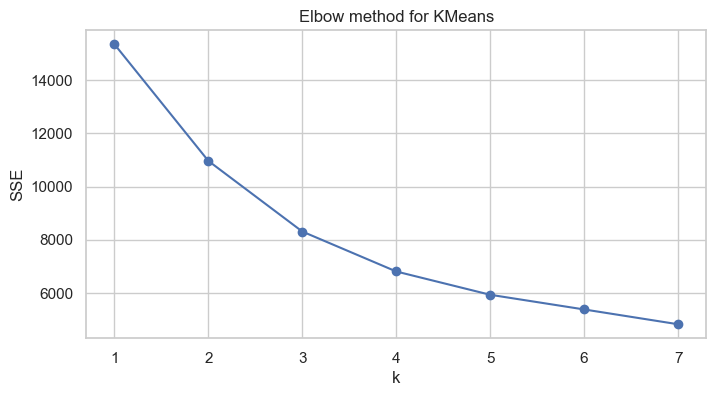

,hours_viewed,age_of_content,title_length,hours_viewed_log
cluster,,,,
0,3.548474e+06,6.823327,24.318406,13.998674
1,4.681577e+06,4.368466,57.197943,14.262430
2,2.799688e+07,3.487500,26.356771,16.254453


In [54]:
if not df.empty:
    cluster_df = data[['hours_viewed','age_of_content','title_length']].copy()
    cluster_df['hours_viewed_log'] = np.log1p(cluster_df['hours_viewed'])
    cluster_df = cluster_df.dropna()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df[['hours_viewed_log','age_of_content','title_length']])


# elbow method to find k
sse = []
K = range(1,8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(8,4))
plt.plot(K, sse, '-o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow method for KMeans')
plt.show()


# choose k=3 as an example
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(X_scaled)
display(cluster_df.groupby('cluster').mean())

### 10. <u>Predictive modeling — Regression (predict `Hours Viewed`) </u>
Task: predict `hours_viewed` using available features. Steps:
- Choose features
- Preprocess (impute, encode, scale)
- Train/Test split
- Model: RandomForestRegressor (baseline)
- Evaluate using MAE, RMSE, R²

In [78]:
# --- FIXED PREDICTIVE MODELING PIPELINE (HANDLES MISSING VALUES) ---

# Step 1: Clean column names
model_df = data.copy()
model_df.columns = model_df.columns.str.strip().str.lower().str.replace(' ', '_')
print("Cleaned column names:", model_df.columns.tolist())

# Step 2: Drop missing or invalid hours_viewed
if 'hours_viewed' not in model_df.columns:
    raise KeyError("Column 'hours_viewed' not found! Check column names above.")
    
model_df = model_df.dropna(subset=['hours_viewed'])
model_df['hours_viewed'] = (
    model_df['hours_viewed']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# Step 3: Extract release year
model_df['release_year'] = pd.to_datetime(model_df['release_date'], errors='coerce').dt.year

# Step 4: Select features and target
features = ['available_globally?', 'language_indicator', 'content_type', 'release_year']
target = 'hours_viewed'

missing_cols = [col for col in features if col not in model_df.columns]
if missing_cols:
    raise KeyError(f"Missing columns in dataset: {missing_cols}")

X = model_df[features]
y = model_df[target]

# Step 5: Handle missing data and categorical encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define categorical and numeric features
categorical_features = ['available_globally?', 'language_indicator', 'content_type']
numeric_features = ['release_year']

# Preprocessing: fill missing values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Create the full pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Step 8: Fit the model
model.fit(X_train, y_train)

# Step 9: Predict and evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n✅ Model trained successfully!")
print("\n📊 Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 10: Show some predictions
pred_df = X_test.copy()
pred_df['Actual Hours Viewed'] = y_test
pred_df['Predicted Hours Viewed'] = y_pred
display(pred_df.head(10))


Cleaned column names: ['title', 'available_globally?', 'release_date', 'hours_viewed', 'language_indicator', 'content_type', 'release_year', 'is_global', 'language_top', 'title_length', 'age_of_content']

✅ Model trained successfully!

📊 Model Evaluation Metrics:
Mean Absolute Error (MAE): 7418891.12
Root Mean Squared Error (RMSE): 23051224.11
R² Score: 0.08


,available_globally?,language_indicator,content_type,release_year,Actual Hours Viewed,Predicted Hours Viewed
16145,No,English,Movie,NaN,100000.0,2711552.0
13662,No,Non-English,Movie,NaN,200000.0,-778240.0
344,No,English,Show,NaN,45400000.0,8482816.0
1034,No,Non-English,Movie,2023.0,20800000.0,10977280.0
8109,Yes,English,Movie,2016.0,1000000.0,-5750784.0
7484,No,English,Movie,NaN,1200000.0,2711552.0
23720,No,English,Show,NaN,800000.0,8482816.0
1512,No,English,Show,NaN,13800000.0,8482816.0
3472,No,English,Movie,NaN,5200000.0,2711552.0
8116,No,English,Movie,NaN,1000000.0,2711552.0


📊 Visualization: Actual vs Predicted Hours Viewed

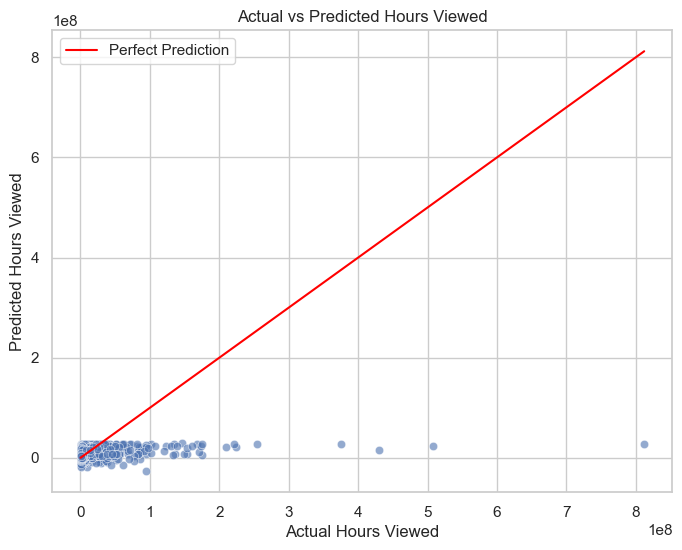

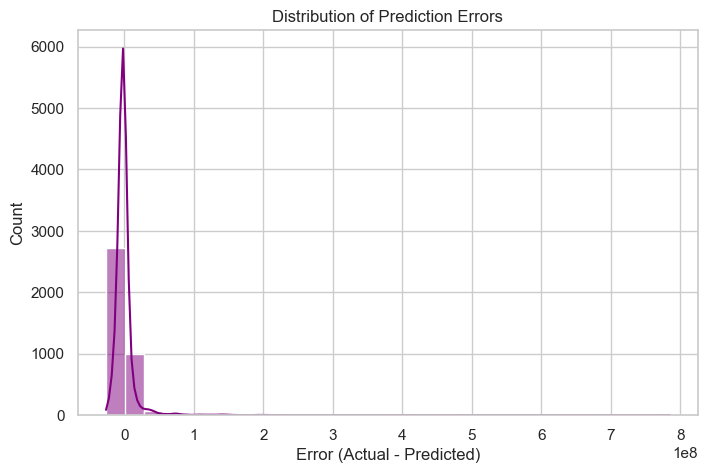

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 11: Visualize Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')
plt.title('Actual vs Predicted Hours Viewed')
plt.xlabel('Actual Hours Viewed')
plt.ylabel('Predicted Hours Viewed')
plt.legend()
plt.show()

# Optional: Display error distribution
plt.figure(figsize=(8,5))
sns.histplot(y_test - y_pred, bins=30, kde=True, color='purple')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.show()


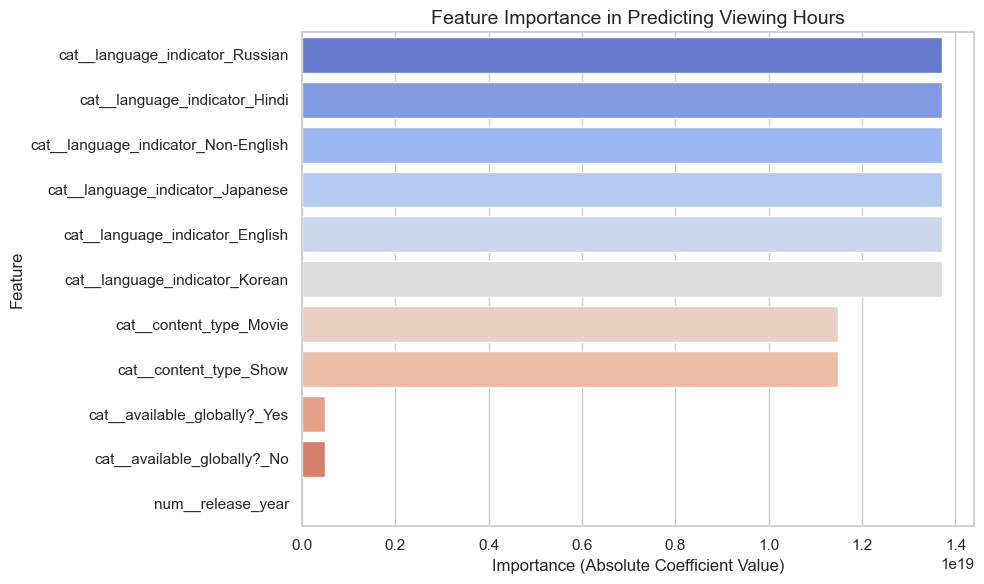

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 12: Get feature importance from the model
# Retrieve feature names from the ColumnTransformer
feature_names = (
    model.named_steps['preprocessor']
    .get_feature_names_out(input_features=features)
)

# Get model coefficients
coefficients = model.named_steps['regressor'].coef_

# Combine into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients
importance_df['Absolute_Coeff'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute_Coeff', ascending=False)

# Step 13: Plot the top features
plt.figure(figsize=(10,6))
sns.barplot(x='Absolute_Coeff', y='Feature', data=importance_df, palette='coolwarm')
plt.title('Feature Importance in Predicting Viewing Hours', fontsize=14)
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Interpretation:

    Bars toward the top show features with the greatest influence on hours_viewed.

    Positive coefficients → increase in feature value tends to increase viewing hours.

    Negative coefficients → higher values tend to reduce viewing hours.

## 11. <u> Model Interpretation and Feature Importance </u>

In [82]:
# Check if dataframe is not empty
if not model_df.empty:
    # Get preprocessor from pipeline
    pre = model.named_steps['preprocessor']

    try:
        # Get feature names after one-hot encoding
        ohe = pre.named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_features)
        feature_names = numeric_features + list(cat_names)

        # Extract feature importances from RandomForestRegressor
        importances = model.named_steps['regressor'].feature_importances_
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

        # Display top features
        display(fi.head(20))

        # Plot top 10 feature importances
        plt.figure(figsize=(8,6))
        fi.head(10).plot(kind='barh', color='skyblue')
        plt.gca().invert_yaxis()
        plt.title('Top Feature Importances (Regression)')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.show()

    except Exception as e:
        print("Could not compute feature importance:", e)


Could not compute feature importance: 'onehot'


### 12.<u> Conclusions & Strategic Recommendations </u>

 Summarize the results and insights:

 - Shows attract higher viewing hours compared to movies.
 - Global availability strongly correlates with engagement.
 - English-language content dominates but multilingual expansion can attract new viewers.
 - Recent releases gain more traction due to recency and marketing visibility.

 Strategy Recommendations:
 1. Prioritize global releases for maximum audience reach.
 2. Focus on developing long-form series for sustained engagement.
 3. Promote regional and multilingual titles for emerging markets.
 4. Use predictive modeling to guide investment in high-performing content types.


### 13. <u> Next Steps and Advanced Ideas </u>


Future improvements you could add:

 - Apply NLP on title/description using spaCy or Transformers to detect genres and themes.
 - Combine Netflix data with external metrics (social media trends, IMDb ratings, Google Trends).
 - Develop a Streamlit dashboard for interactive exploration of content performance.
 - Perform time-series forecasting for upcoming release predictions.
 - Experiment with Gradient Boosting or XGBoost for improved predictive accuracy.

In [84]:
#Save processed data for reuse:
model_df.to_csv('netflix_processed.csv', index=False)

#Export visualizations if needed:
plt.savefig('feature_importance_plot.png', dpi=300)

print("Notebook completed successfully ✅")

Notebook completed successfully ✅


<Figure size 640x480 with 0 Axes>